[View in Colaboratory](https://colab.research.google.com/github/yylonly/ServeNet/blob/master/4_ServeNet_2D_CNN_1_BI_LTSM(512)_FC_(Glove200b_trainedEmbeddingLayer).ipynb)

## ServeNet

In [1]:
seed = 12345

import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/keras-team/keras/issues/2280#issuecomment-306959926

import os
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(seed)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(seed)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(seed)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Rest of code follows ...

Using TensorFlow backend.


In [2]:
#import plaidml.keras
#plaidml.keras.install_backend()


import matplotlib.pyplot as plt
import seaborn as sns
import csv
import h5py
import pandas as pd

#from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.models import load_model
from keras import metrics
from keras.layers import Dense, Input, Dropout, LSTM, Activation, Conv2D, Reshape, Average
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.initializers import glorot_uniform
from keras.callbacks import ModelCheckpoint
from keras.layers.wrappers import Bidirectional
from keras.initializers import Orthogonal

%matplotlib inline

## 1. Load data

In [3]:
h5f = h5py.File('../Data/SplittedPaddedIndexedServiceDataset.h5','r') 
X_train = h5f['indexed_padded_Train_X'][:]
Y_train = h5f['Train_Y_one_hot'][:]
X_test = h5f['indexed_padded_Test_X'][:]
Y_test = h5f['Test_Y_one_hot'][:]
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
h5f.close()

(8123, 110) (8123, 50)
(2061, 110) (2061, 50)


In [4]:
X_train[0]

array([357266, 146233, 306318,  68100, 268046, 340949, 226138, 192973,
       269953, 268046,   8172, 304244, 306318,  68159, 188481, 357266,
       146211, 350362, 357266, 306262, 126057, 268046, 357266,  68100,
       225650, 360915, 293378, 297112, 133215, 306262,  54718, 108280,
       360915, 133215, 287783, 125166, 188481, 348215, 268046, 358160,
       163265, 193716, 174032, 111449,  57488, 357212, 220870, 122453,
        45107, 357266, 117493, 343876, 269798, 193919, 384515, 333113,
       357266, 153371,  57459, 220930, 374205, 297544, 357266, 146233,
       306318, 133215, 117493, 153371,  54718,  58800, 146233, 306318,
       133215, 117493,  51203, 117505, 360915, 306966, 339034, 117493,
       357266, 306162, 117493,  90548,  71090, 114153,  45217, 360915,
       117493, 338227, 305005,  93724, 325550,  54718, 272583, 291376,
       357266,  57459, 374208, 306616,  89943,  54718, 306550,  58997,
       151766, 188481, 392023,      0,      0,      0], dtype=int32)

In [5]:
Y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## 2. ServeNet - Embedding Layer

In [6]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding="utf-8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [7]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('../Data/glove.6B.200d.txt')

In [8]:
# GRADED FUNCTION: pretrained_embedding_layer

def trainable_embedding_layer():
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        embedding_vector = word_to_vec_map.get(word)
        if embedding_vector is not None:
            emb_matrix[index, :] = embedding_vector

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

## 2. ServeNet - Model

In [9]:
def ServiceLSTM(input_shape):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    ### START CODE HERE ###
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = trainable_embedding_layer()
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices) 
     
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(256, return_sequences=False)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(50)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)
    
    ### END CODE HERE ###
    
    ### END CODE HERE ###
    
    return model

In [10]:
maxLen = 110

In [11]:
model = ServiceLSTM((maxLen, ))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 110)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 110, 200)          80000200  
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               467968    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                12850     
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
Total params: 80,481,018
Trainable params: 480,818
Non-trainable params: 80,000,200
__________________________________________________________

In [12]:
#for i in range(len(model.layers)):
#  print(model.layers[i].get_weights())

In [13]:
#for i in range(len(model.layers)):
#  print(model.layers[i].get_weights())

In [14]:
checkpointer = ModelCheckpoint(filepath='../Data/LSTM.hdf5', monitor='val_top_k_categorical_accuracy', verbose=1, save_best_only=True)

In [15]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0)

In [16]:
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=[metrics.top_k_categorical_accuracy, metrics.categorical_accuracy])

In [17]:
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 40, batch_size = 64, verbose = 1, shuffle=False, callbacks=[checkpointer])

Train on 8123 samples, validate on 2061 samples
Epoch 1/40
8123/8123 [==============================] - 32s 4ms/step - loss: 3.7693 - top_k_categorical_accuracy: 0.2515 - categorical_accuracy: 0.0649 - val_loss: 3.7225 - val_top_k_categorical_accuracy: 0.2635 - val_categorical_accuracy: 0.0723

Epoch 00001: val_top_k_categorical_accuracy improved from -inf to 0.26346, saving model to ../Data/LSTM.hdf5
Epoch 2/40
8123/8123 [==============================] - 31s 4ms/step - loss: 3.7322 - top_k_categorical_accuracy: 0.2610 - categorical_accuracy: 0.0689 - val_loss: 3.7185 - val_top_k_categorical_accuracy: 0.2630 - val_categorical_accuracy: 0.0718

Epoch 00002: val_top_k_categorical_accuracy did not improve from 0.26346
Epoch 3/40
8123/8123 [==============================] - 31s 4ms/step - loss: 3.7576 - top_k_categorical_accuracy: 0.2596 - categorical_accuracy: 0.0725 - val_loss: 3.7213 - val_top_k_categorical_accuracy: 0.2620 - val_categorical_accuracy: 0.0713

Epoch 00003: val_top_k_cat

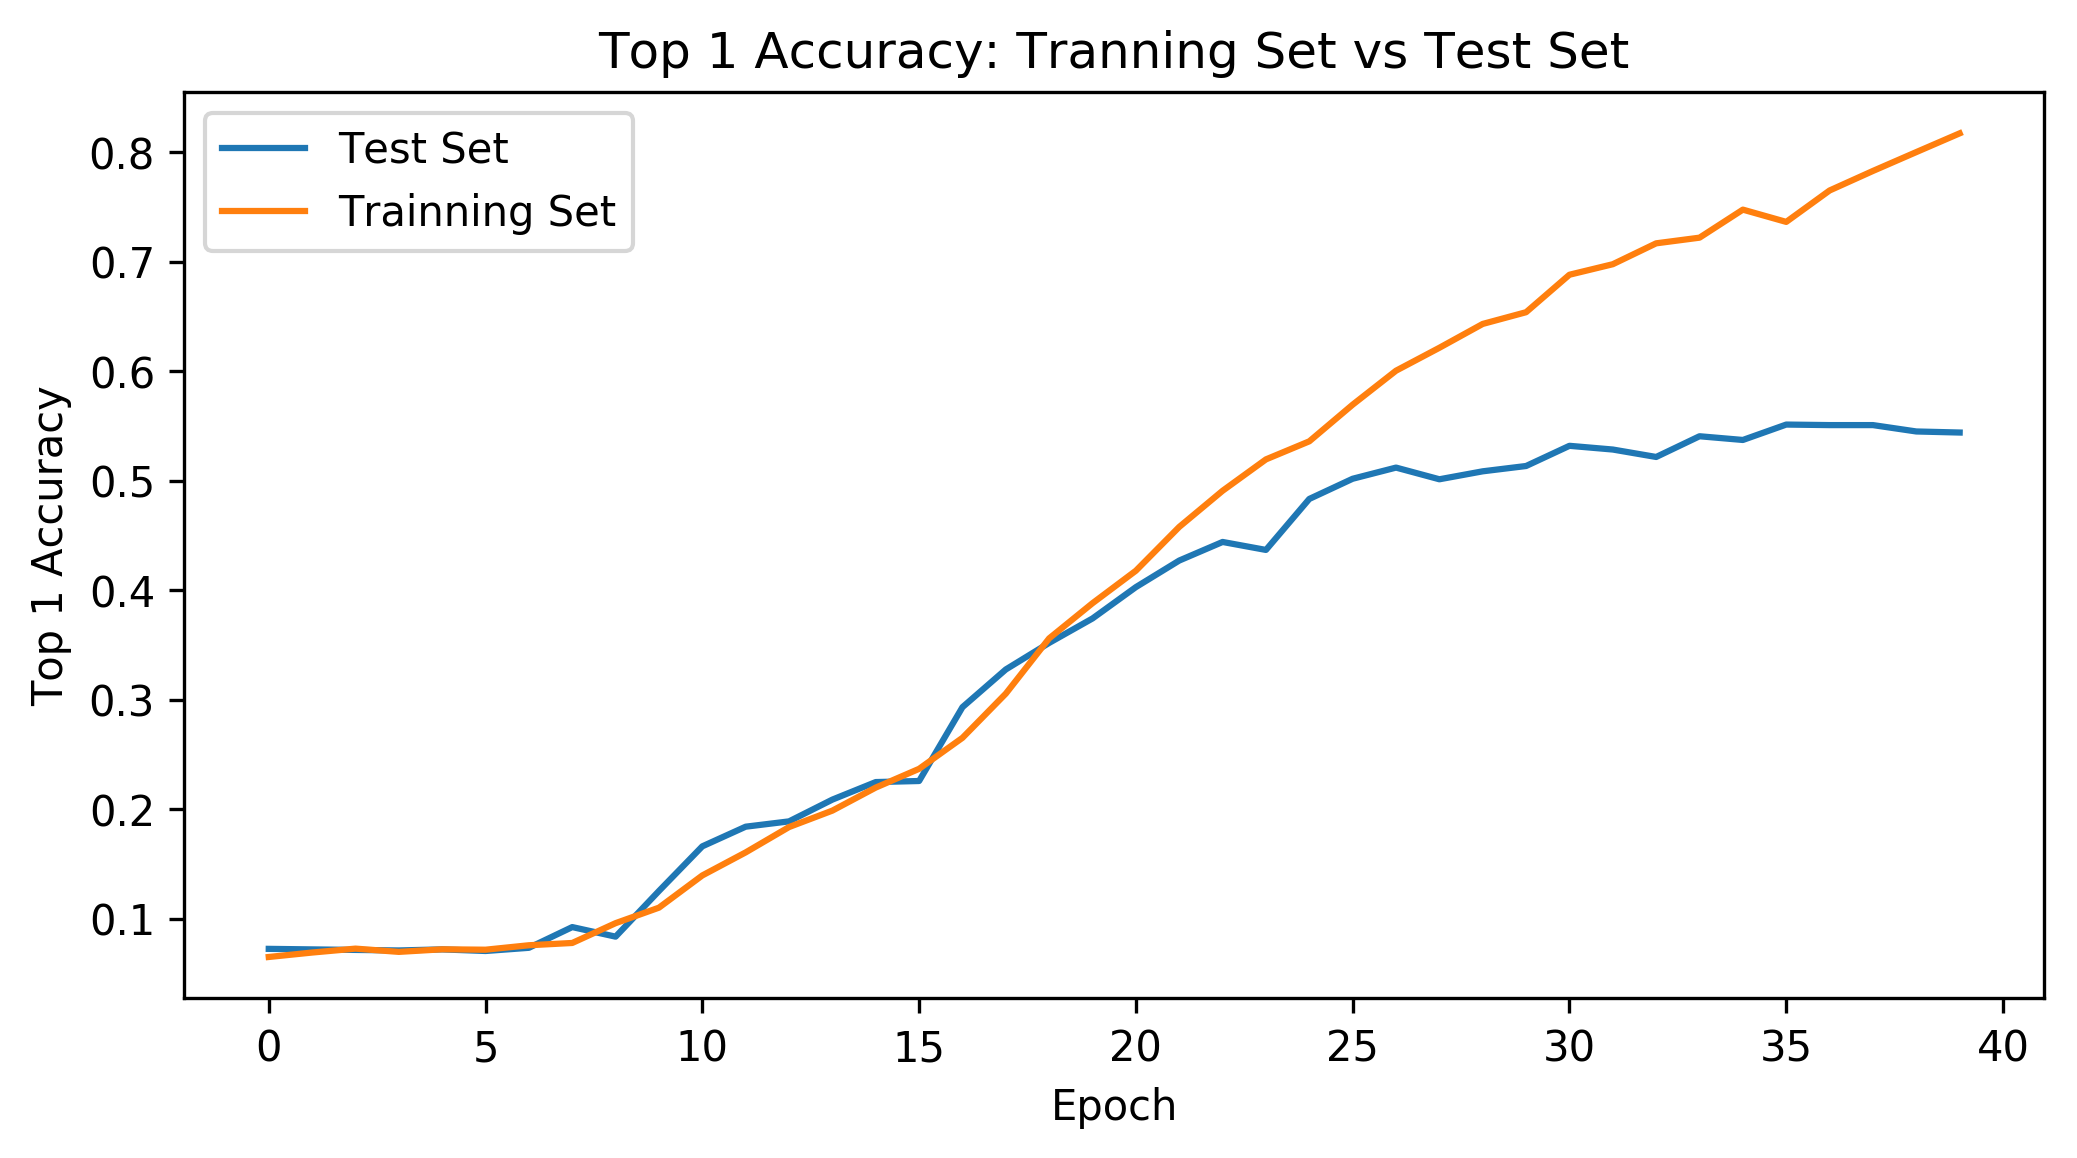

<Figure size 432x288 with 0 Axes>

In [18]:
# plot metrics
plt.figure(figsize=(8, 4), dpi=300)
plt.title("Top 1 Accuracy: Tranning Set vs Test Set")
plt.xlabel("Epoch")
plt.ylabel("Top 1 Accuracy")
plt.plot(history.history['val_categorical_accuracy'], label="Test Set")
plt.plot(history.history['categorical_accuracy'], label="Trainning Set")
plt.legend()
plt.show()
plt.savefig('LSTMTop1.pdf', format='pdf', dpi=300)

### Plot Loss

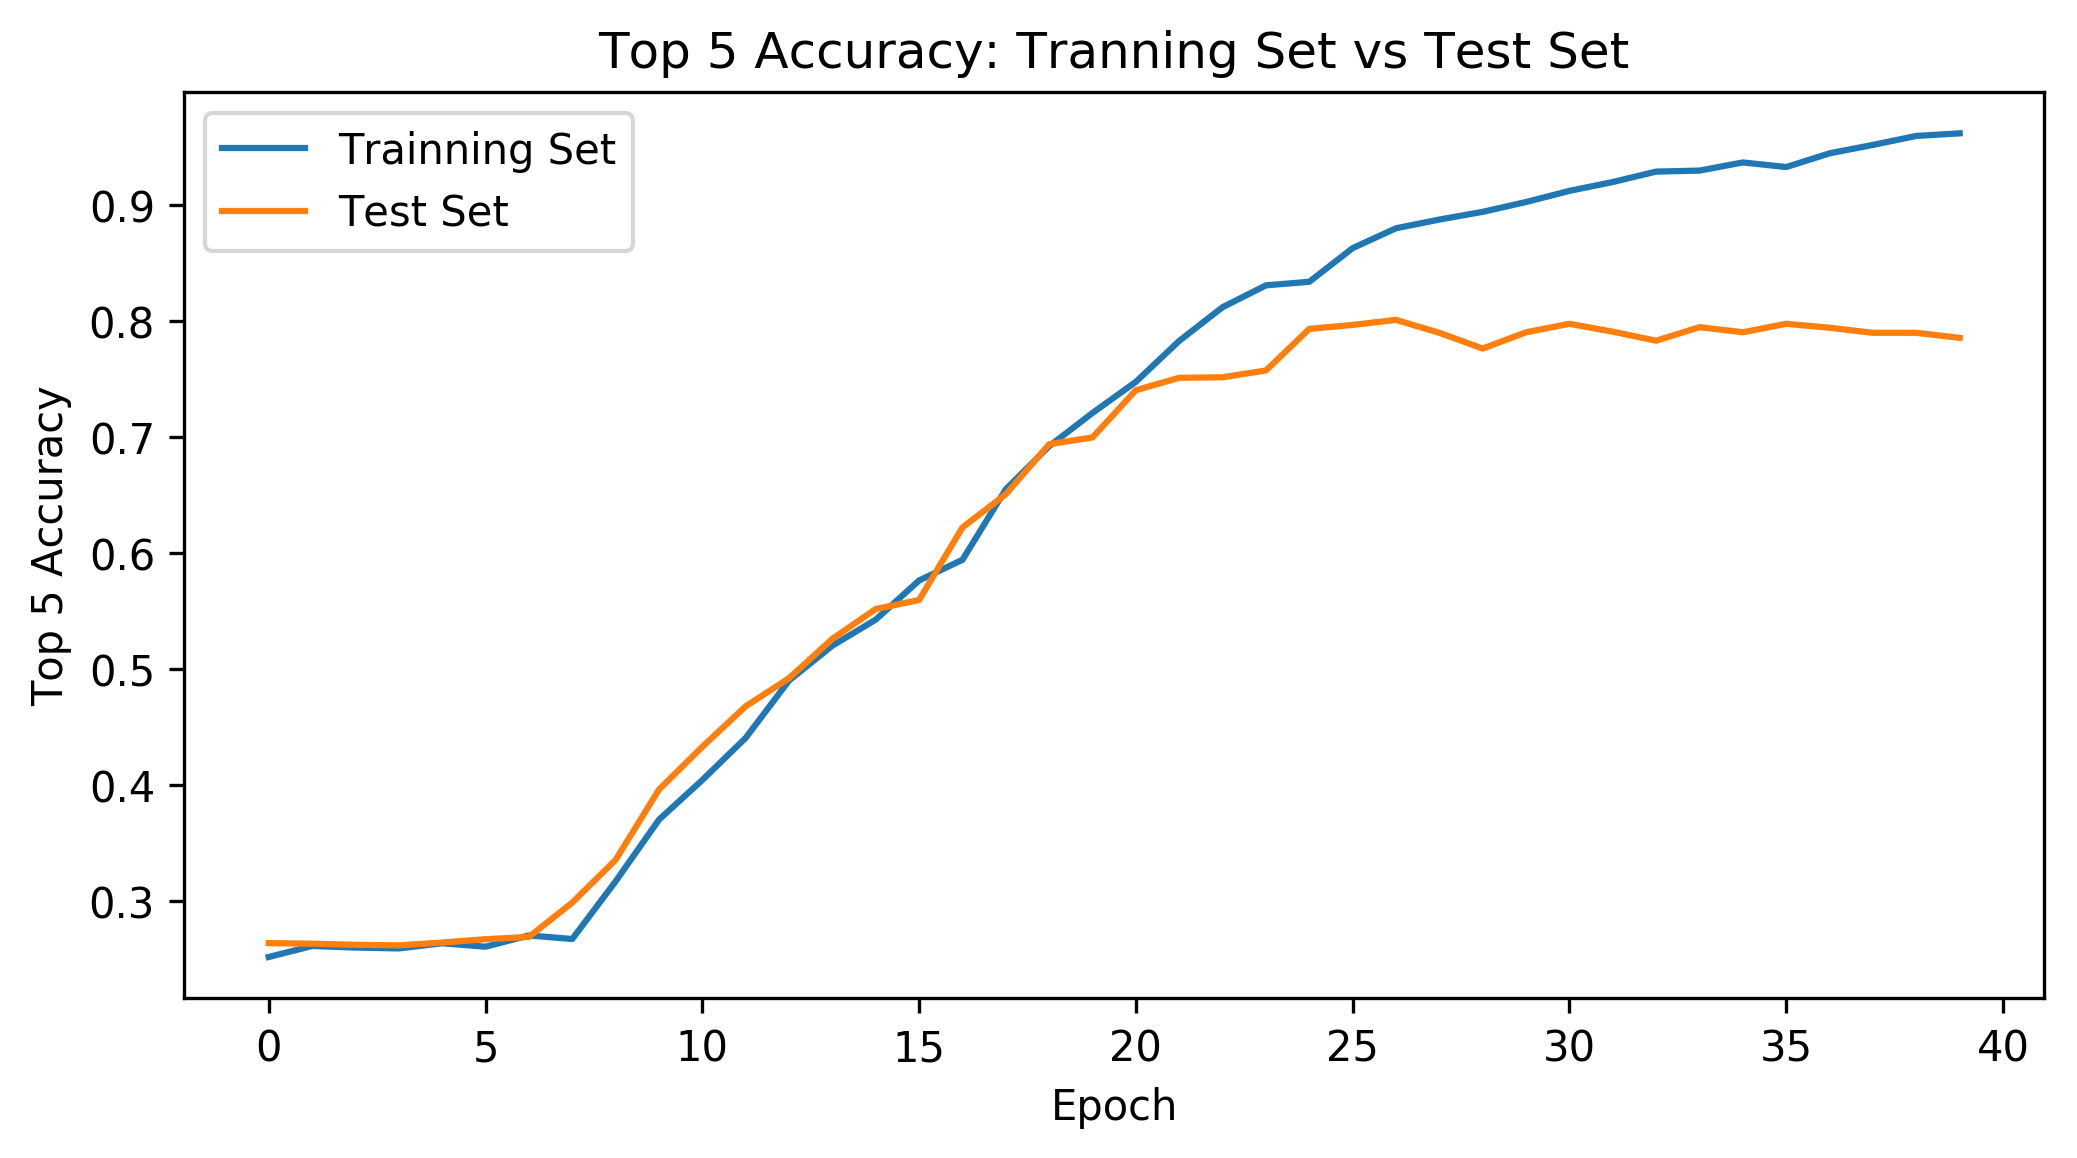

<Figure size 432x288 with 0 Axes>

In [19]:
# plot metrics
plt.figure(figsize=(8, 4), dpi=300)
plt.title("Top 5 Accuracy: Tranning Set vs Test Set")
plt.xlabel("Epoch")
plt.ylabel("Top 5 Accuracy")
plt.plot(history.history['top_k_categorical_accuracy'], label="Trainning Set")
plt.plot(history.history['val_top_k_categorical_accuracy'], label="Test Set")
plt.legend()
plt.show()
plt.savefig('LSTMTop5.pdf', format='pdf', dpi=300)

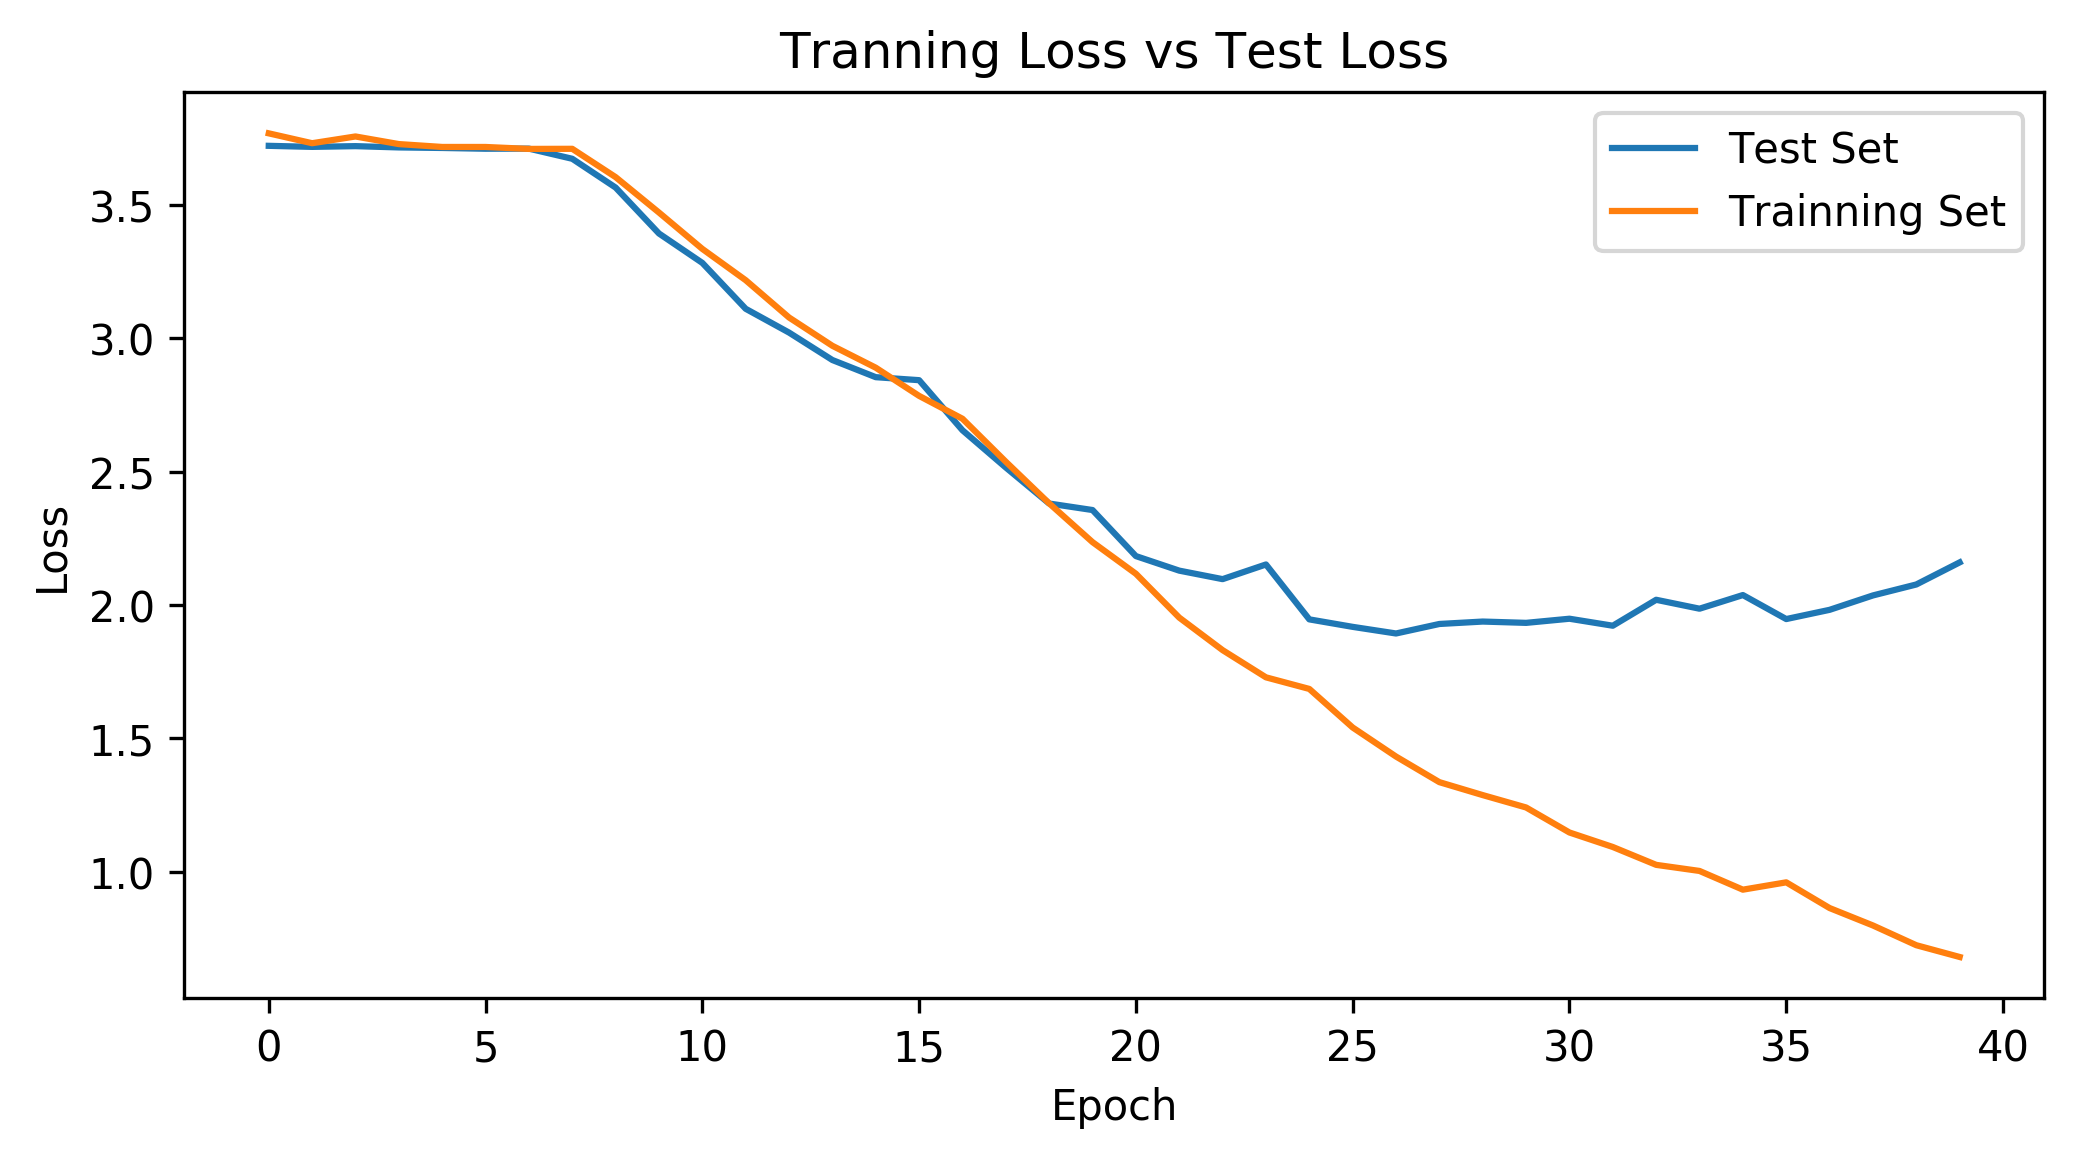

<Figure size 432x288 with 0 Axes>

In [20]:
# plot metrics
plt.figure(figsize=(8, 4), dpi=300)
plt.title("Tranning Loss vs Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['val_loss'], label="Test Set")
plt.plot(history.history['loss'], label="Trainning Set")
plt.legend()
plt.show()
plt.savefig('LSTMLoss.pdf', format='pdf', dpi=300)

### Save History

In [21]:
import pickle
  
f = open('LSTMHistory', 'wb')
pickle.dump(history.history, f)
f.close()

### Load History

In [22]:
import pickle

f = open('LSTMHistory', 'rb')
his = pickle.load(f)
f.close()

In [23]:
val_top_k = his['val_top_k_categorical_accuracy']
print("top5: ", max(val_top_k))
print(np.argmax(val_top_k))
val_loss = his['val_loss']
print("loss: ", min(val_loss))
print(np.argmin(val_loss))
val_ca = his['val_categorical_accuracy']
print("top1: ", max(val_ca))
print(np.argmax(val_ca))

top5:  0.8010674430177607
26
loss:  1.8935368192942035
26
top1:  0.5511887434730826
35


### Model Save (delete)

In [24]:
#model.save('ServeNet.h5') 

### Model Load

In [4]:
model = load_model('../Data/LSTM.hdf5')

In [5]:
print("Training set:")
loss_train, top5error_train, top1error_train = model.evaluate(X_train, Y_train)
print("Top5 Training accuracy = ", top5error_train)
print("Top1 Training accuracy = ", top1error_train)
print('Test set:')
loss_test, top5error_test, top1error_test = model.evaluate(X_test, Y_test)
print("Training accuracy = ", top5error_test)
print("Top1 Training accuracy = ", top1error_test)

Training set:
8123/8123 [==============================] - 18s 2ms/step
Top5 Training accuracy =  0.9022528622430137
Top1 Training accuracy =  0.6341253230977671
Test set:
2061/2061 [==============================] - 4s 2ms/step
Training accuracy =  0.8010674430177607
Top1 Training accuracy =  0.5118874334294145


In [6]:
# This code allows you to see the mislabelled examples
C = 50
# y_test_oh = np.eye(C)[Y_test.reshape(-1)]
# X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
predY_test = model.predict(X_test)

## Compute top-1 accuracy

In [28]:
print(predY_test.shape)
print(Y_test.shape)

(2061, 50)
(2061, 50)


In [29]:
print(np.argmax(predY_test[0]))
print(np.argmax(Y_test[0]))

11
11


In [30]:
# Heatmap Data
non_onehot_pred_test = np.argmax(predY_test, axis=1)
non_onehot_Y_test = np.argmax(Y_test, axis=1)
categories = [
"eCommerce",
"Photos",
"Stocks",
"Chat",
"Telephony",
"Medical",
"Backend",
"Travel",
"Domains",
"Data",
"Internet of Things",
"Transportation",
"Government",
"Marketing",
"File Sharing",
"Enterprise",
"Cloud",
"Games",
"Financial",
"Weather",
"Payments",
"Science",
"Email",
"Project Management",
"Other",
"Tools",
"Database",
"Storage",
"Banking",
"Application Development",
"Real Estate",
"Bitcoin",
"Messaging",
"Media",
"Security",
"Analytics",
"Entertainment",
"Images",
"Video",
"Sports",
"Education",
"News Services",
"Search",
"Shipping",
"Music",
"Events",
"Reference",
"Social",
"Mapping",
"Advertising", "All"]

print(non_onehot_pred_test.shape)
print(non_onehot_Y_test.shape)


(2061,)
(2061,)


## Compute correct number on each category

In [31]:
len(non_onehot_Y_test)

2061

In [32]:
non_onehot_Y_test[0]

11

In [33]:
np.argwhere(non_onehot_pred_test == 3)

array([[ 141],
       [ 216],
       [ 397],
       [ 594],
       [ 683],
       [1188],
       [1417],
       [1519],
       [1647],
       [1756],
       [1814],
       [2035],
       [2059]])

In [34]:
np.argwhere(non_onehot_Y_test == 3)

array([[  10],
       [  59],
       [ 141],
       [ 397],
       [ 594],
       [1025],
       [1069],
       [1188],
       [1304],
       [1423],
       [1500],
       [1647],
       [1716],
       [1756],
       [2006],
       [2035]])

In [35]:
# Heat Map

# cross = pd.crosstab(non_onehot_Y_test, non_onehot_pred_test.reshape(len(non_onehot_pred_test),), rownames=['Actual'], colnames=['Predicted'], margins=True)
cross = pd.crosstab(non_onehot_Y_test, pd.Categorical(non_onehot_pred_test, categories=list(range(0,50))), rownames=['Actual'], colnames=['Predicted'], margins=True, dropna=False)  

In [36]:
cross.index = categories
# cross.index.name = "Actual"
# cross.columns = categories
# cross.columns.name = "Predicted"
cross.head()

Predicted,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,All
eCommerce,56,1,0,0,2,0,0,0,0,0,...,0,1,0,0,0,1,0,0,5,86
Photos,0,22,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,35
Stocks,0,0,15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,19
Chat,0,0,0,7,1,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,16
Telephony,0,0,0,1,37,0,0,0,0,0,...,0,0,0,0,0,0,1,3,0,57


## Compute category accuracy

In [37]:
all = cross["All"]

In [38]:
result = []

all = cross["All"]

for i in range(0, 50):
    acc = cross.iloc[i,i] / all[i]
    result.append(acc)     

## Save acc in JSON file

In [39]:
acc_category = dict(zip(categories, result)) 

import json
with open('../Data/LSTM_acc_category.json', 'w') as fp:
    json.dump(acc_category, fp)

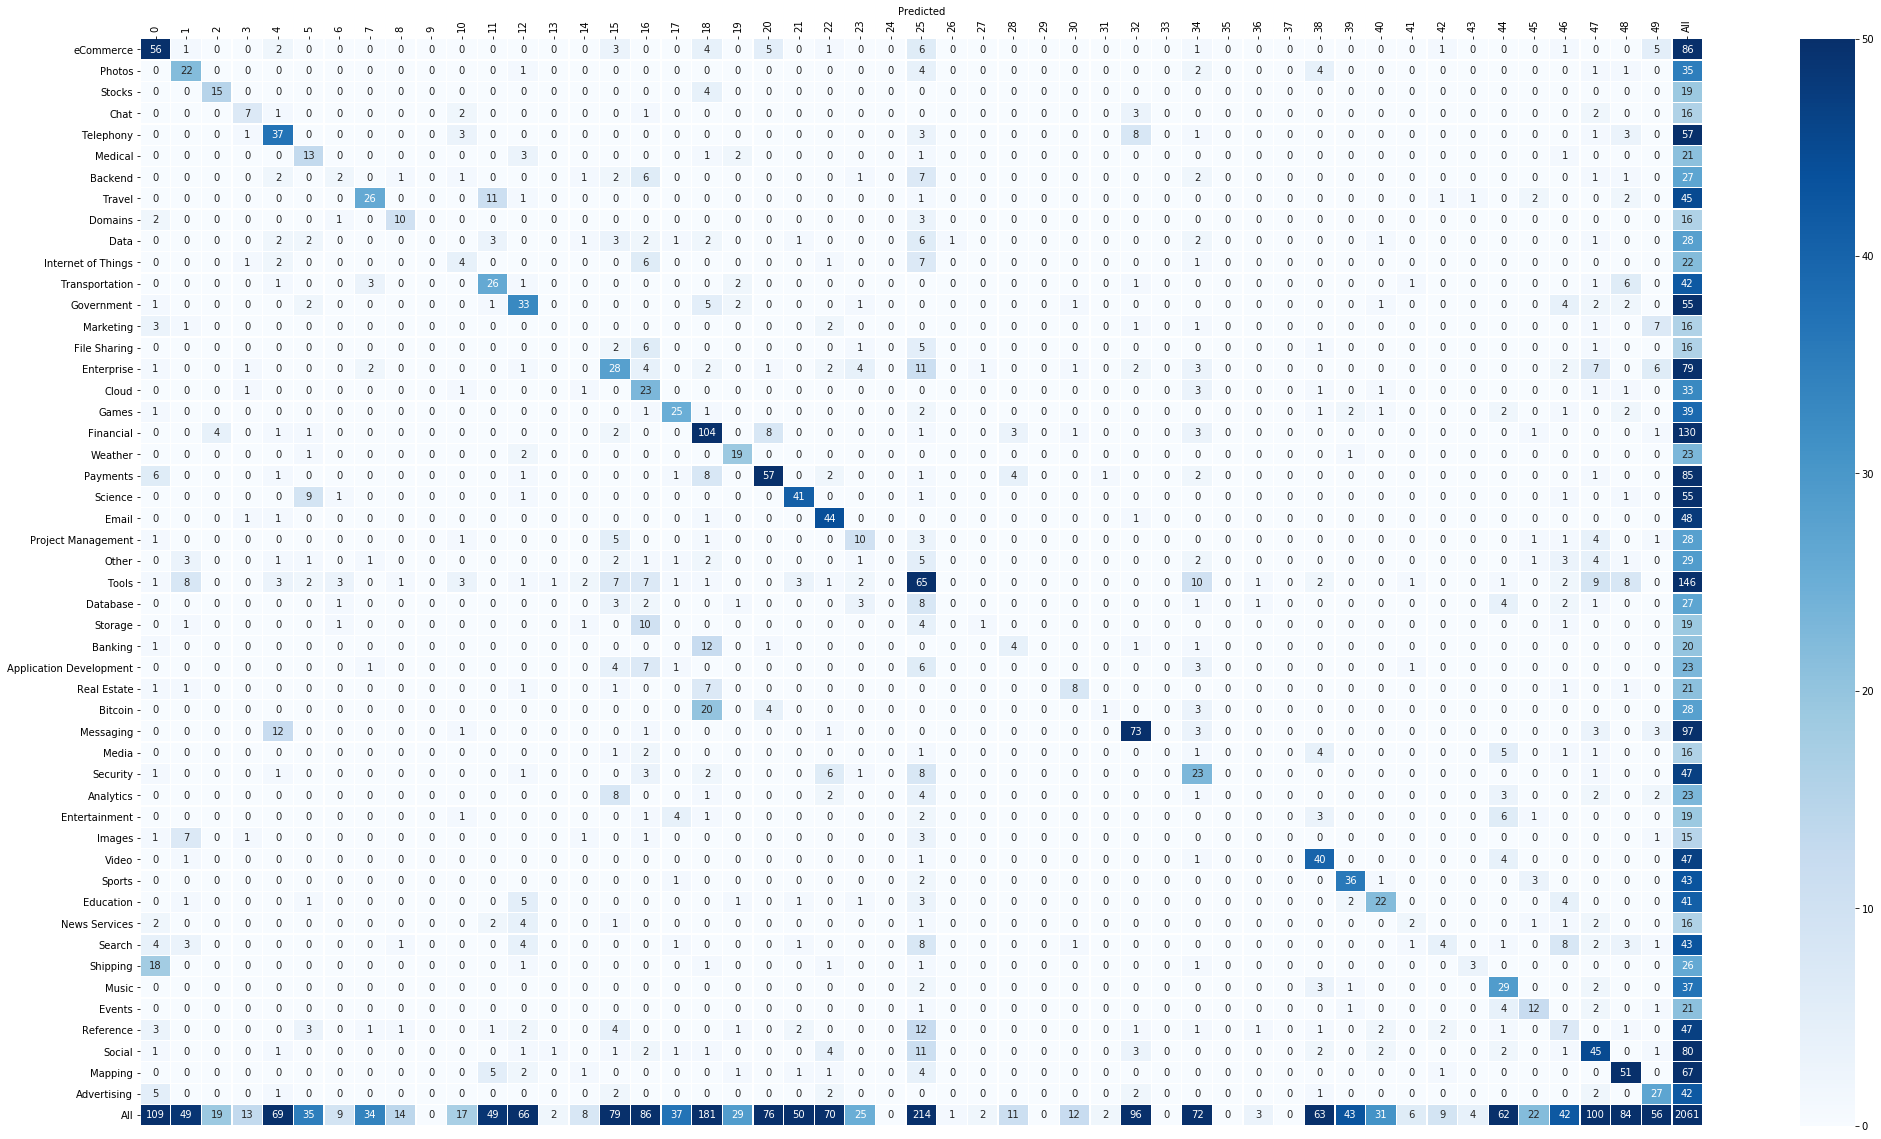

In [40]:
f, ax = plt.subplots(figsize=(35,20))

sns.heatmap(cross, annot=True, vmin=0, fmt="d", vmax=50, ax=ax, linewidths=.3, cmap=plt.cm.Blues)

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')


plt.yticks(rotation=0) 
plt.xticks(rotation=90) 

plt.savefig('LSTMHeatMap.pdf', format='pdf', dpi=300)

## Compute Top-5 on categories

In [7]:
print(np.argmax(predY_test[0]))
print(np.argmax(Y_test[0]))

11
11


In [8]:
predY_test[0]

array([2.99838983e-04, 8.10937199e-05, 3.60302074e-05, 5.24622737e-06,
       1.12722526e-04, 4.05015089e-05, 6.55380836e-06, 4.06027019e-01,
       2.72528232e-05, 5.39569464e-03, 1.55006346e-04, 5.71096957e-01,
       7.44481804e-04, 1.03638240e-05, 4.08711867e-06, 4.78313777e-05,
       1.08747390e-05, 7.03367550e-05, 3.33662829e-05, 3.88688059e-03,
       3.00285228e-05, 1.68649858e-05, 1.21451340e-05, 1.83637731e-05,
       8.19038250e-05, 6.16222824e-05, 2.24428659e-05, 1.32034993e-05,
       6.11117503e-06, 1.56570095e-05, 1.16550655e-04, 2.78233529e-05,
       4.17109550e-05, 1.61005264e-05, 7.70224506e-06, 6.01434749e-06,
       3.53061390e-04, 2.20140719e-05, 1.18517037e-05, 4.19104891e-03,
       4.60838673e-05, 2.22689807e-04, 1.38141477e-04, 1.22112781e-03,
       2.00614522e-04, 2.20294460e-03, 1.61372591e-04, 1.25650011e-04,
       2.42495118e-03, 9.20519087e-05], dtype=float32)

In [9]:
predY_test[0].argsort()

array([14,  3, 35, 28,  6, 34, 13, 16, 38, 22, 27, 29, 33, 21, 23, 37, 26,
        8, 31, 20, 18,  2,  5, 32, 40, 15, 25, 17,  1, 24, 49,  4, 30, 47,
       42, 10, 46, 44, 41,  0, 36, 12, 43, 45, 48, 19, 39,  9,  7, 11])

In [10]:
predY_test[0].argsort()[-5:][::-1]

array([11,  7,  9, 39, 19])

In [11]:
predY_test[0].argsort()[-5:][::-1]

array([11,  7,  9, 39, 19])

In [12]:
np.argsort(predY_test, axis=-1)[:, -5:][:, ::-1]

array([[11,  7,  9, 39, 19],
       [44, 36, 38, 33, 47],
       [45, 47, 46, 17, 44],
       ...,
       [25, 46, 40, 26, 24],
       [ 3, 47,  4, 15, 25],
       [ 0, 43, 49, 15, 13]])

In [13]:
a = [1, 2, 3, 4,5]
6 in a

False

In [14]:
# If predict top5 includes true value, set true value to pred_test set
non_onehot_Y_test = np.argmax(Y_test, axis=1)
non_onehot_pred_test = np.zeros((non_onehot_Y_test.shape))
non_onehot_pred_test_top5 = np.argsort(predY_test, axis=-1)[:, -5:][:, ::-1]

m = non_onehot_Y_test.shape[0]

for i in range(0, m):
    if non_onehot_Y_test[i] in non_onehot_pred_test_top5[i]:
        non_onehot_pred_test[i] = non_onehot_Y_test[i]

In [15]:
categories = [
"eCommerce",
"Photos",
"Stocks",
"Chat",
"Telephony",
"Medical",
"Backend",
"Travel",
"Domains",
"Data",
"Internet of Things",
"Transportation",
"Government",
"Marketing",
"File Sharing",
"Enterprise",
"Cloud",
"Games",
"Financial",
"Weather",
"Payments",
"Science",
"Email",
"Project Management",
"Other",
"Tools",
"Database",
"Storage",
"Banking",
"Application Development",
"Real Estate",
"Bitcoin",
"Messaging",
"Media",
"Security",
"Analytics",
"Entertainment",
"Images",
"Video",
"Sports",
"Education",
"News Services",
"Search",
"Shipping",
"Music",
"Events",
"Reference",
"Social",
"Mapping",
"Advertising", "All"]

print(non_onehot_pred_test.shape)
print(non_onehot_pred_test.shape)

(2061,)
(2061,)


## Compute correct number on each category (top5)

In [16]:
# Heat Map

# cross = pd.crosstab(non_onehot_Y_test, non_onehot_pred_test.reshape(len(non_onehot_pred_test),), rownames=['Actual'], colnames=['Predicted'], margins=True)
cross = pd.crosstab(non_onehot_Y_test, non_onehot_pred_test, rownames=['Actual'], colnames=['Predicted'], margins=True)  

In [17]:
cross.index = categories
cross.index.name = "Actual"
cross.columns = categories
cross.columns.name = "Predicted"
cross.head()

Predicted,eCommerce,Photos,Stocks,Chat,Telephony,Medical,Backend,Travel,Domains,Data,...,News Services,Search,Shipping,Music,Events,Reference,Social,Mapping,Advertising,All
Actual,,,,,,,,,,,,,,,,,,,,,
eCommerce,86,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,86
Photos,5,30,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,35
Stocks,0,0,19,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,19
Chat,3,0,0,13,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16
Telephony,4,0,0,0,53,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,57


In [18]:
cross.columns

Index(['eCommerce', 'Photos', 'Stocks', 'Chat', 'Telephony', 'Medical',
       'Backend', 'Travel', 'Domains', 'Data', 'Internet of Things',
       'Transportation', 'Government', 'Marketing', 'File Sharing',
       'Enterprise', 'Cloud', 'Games', 'Financial', 'Weather', 'Payments',
       'Science', 'Email', 'Project Management', 'Other', 'Tools', 'Database',
       'Storage', 'Banking', 'Application Development', 'Real Estate',
       'Bitcoin', 'Messaging', 'Media', 'Security', 'Analytics',
       'Entertainment', 'Images', 'Video', 'Sports', 'Education',
       'News Services', 'Search', 'Shipping', 'Music', 'Events', 'Reference',
       'Social', 'Mapping', 'Advertising', 'All'],
      dtype='object', name='Predicted')

## Compute category accuracy

In [19]:
all = cross["All"]

In [20]:
result = []

all = cross["All"]

for i in range(0, 50):
    acc = cross.iloc[i,i] / all[i]
    result.append(acc)  
    
np.mean(result)

0.7642076015568846

## Save acc in JSON file

In [21]:
acc_category = dict(zip(categories, result)) 

import json
with open('../Data/top5_LSTM_acc_category.json', 'w') as fp:
    json.dump(acc_category, fp)

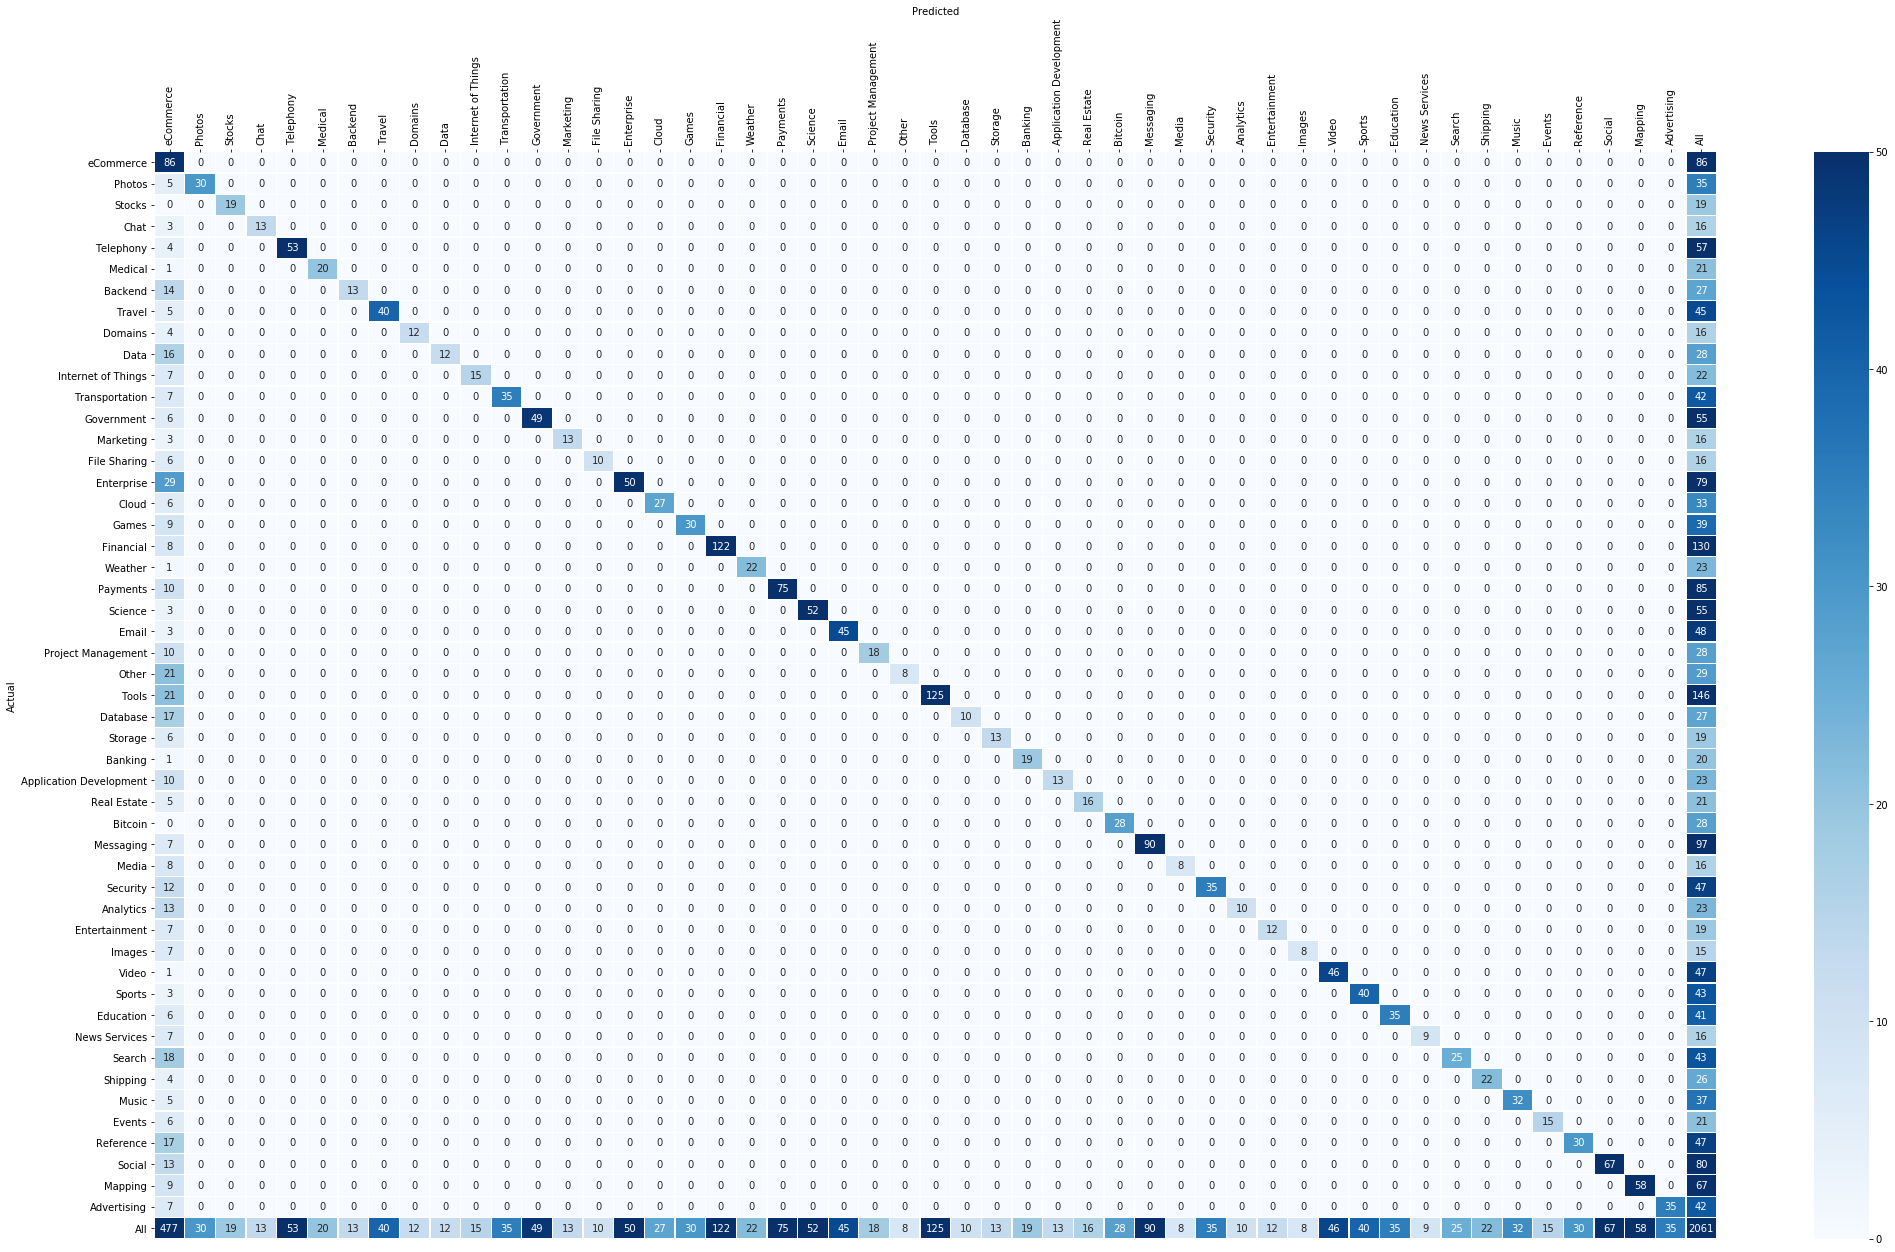

In [22]:
f, ax = plt.subplots(figsize=(35,20))

sns.heatmap(cross, annot=True, vmin=0, fmt="d", vmax=50, ax=ax, linewidths=.3, cmap=plt.cm.Blues)

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')


plt.yticks(rotation=0) 
plt.xticks(rotation=90) 

plt.savefig('Top5-LSTMHeatMap.pdf', format='pdf', dpi=300)